In [69]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
import pandas as pd
from catboost import CatBoostClassifier, Pool, metrics, cv, CatBoostRegressor
from sklearn.model_selection import LeaveOneOut
import math
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from rdkit import Chem
import rdkit
import itertools
from rdkit.Chem import Descriptors
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("final_res_diff_fixed.csv")
df["preorg_energy"] = [-i * 27.2114 for i in df["preorg_energy"]]
df["eg"] = [-i for i in df["eg"]]
vanilla_desc = ["Solven_Epsilon", "Surface_tension", "eg", "esp", "preorg_energy"]
experim_cond = ["C(NaNO3)", "C(HNO3)", "C(NaClO4)", "C(lig)"]
sf_df = df[["smiles", "sf"] + vanilla_desc + experim_cond].dropna()


def train_split_model(X, y, method) -> []:
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
    model = method()
    model.fit(X_train, y_train)

    return y_validation, model.predict(X_validation), model

smiles = sf_df["smiles"]
rdk_desc = []
rdk_desc_names = [i[0] for i in Descriptors._descList]
rdk_desc = [rdk_desc_names.index(i) for i in rdk_desc]
rdk_desc = np.array([[Descriptors._descList[i][1](Chem.MolFromSmiles(s)) for i in rdk_desc] for s in smiles])

vanilla_desc = sf_df[vanilla_desc].astype(float).to_numpy()
experim_cond = sf_df[experim_cond].astype(float).to_numpy()

X = np.append(experim_cond, np.append(vanilla_desc, rdk_desc, axis=1), axis=1)
target = np.log10(sf_df["sf"].to_numpy())
y_true, y_pred, model = train_split_model(X, target, CatBoostRegressor)
print(model)
print(r2_score(y_true, y_pred))
print(math.sqrt(mean_squared_error(y_true, y_pred)))

Learning rate set to 0.025891
0:	learn: 1.5854404	total: 4.98ms	remaining: 4.97s
1:	learn: 1.5683278	total: 5.36ms	remaining: 2.67s
2:	learn: 1.5467251	total: 5.69ms	remaining: 1.89s
3:	learn: 1.5340105	total: 5.94ms	remaining: 1.48s
4:	learn: 1.5114391	total: 6.17ms	remaining: 1.23s
5:	learn: 1.4923127	total: 6.4ms	remaining: 1.06s
6:	learn: 1.4801273	total: 6.63ms	remaining: 940ms
7:	learn: 1.4610323	total: 6.85ms	remaining: 849ms
8:	learn: 1.4483440	total: 7.14ms	remaining: 786ms
9:	learn: 1.4290953	total: 7.38ms	remaining: 730ms
10:	learn: 1.4118414	total: 7.59ms	remaining: 683ms
11:	learn: 1.3933790	total: 7.87ms	remaining: 648ms
12:	learn: 1.3813207	total: 8.14ms	remaining: 618ms
13:	learn: 1.3677241	total: 8.37ms	remaining: 589ms
14:	learn: 1.3523909	total: 8.53ms	remaining: 560ms
15:	learn: 1.3373273	total: 8.75ms	remaining: 538ms
16:	learn: 1.3241096	total: 8.91ms	remaining: 515ms
17:	learn: 1.3114604	total: 9.08ms	remaining: 496ms
18:	learn: 1.3011893	total: 9.22ms	remaining:

In [70]:
X.shape
order = ["C(NaNO3)", "C(HNO3)", "C(NaClO4)", "C(ligand)"] + ["Solvent dielectric\n constant", "Solvent surface\n tension", "Hardness", "ESP", "Preorganization\n energy"]

X_df = pd.DataFrame(data=X,    # values
              index=range(X.shape[0]),    # 1st column as index
              columns=order)
X_df

,C(NaNO3),C(HNO3),C(NaClO4),C(ligand),Solvent dielectric\n constant,Solvent surface\n tension,Hardness,ESP,Preorganization\n energy
0,1.0,0.0001,0.0,0.10,25.00,30.6,2.26335,-0.998045,3.712462
1,1.0,0.0003,0.0,0.10,25.00,30.6,2.26335,-0.998045,3.712462
2,1.0,0.0010,0.0,0.10,25.00,30.6,2.26335,-0.998045,3.712462
3,1.0,0.0032,0.0,0.10,25.00,30.6,2.26335,-0.998045,3.712462
4,1.0,0.0100,0.0,0.10,25.00,30.6,2.26335,-0.998045,3.712462
...,...,...,...,...,...,...,...,...,...
69,0.0,3.0000,0.0,0.01,34.82,43.9,1.83395,-2.780000,2.679506
70,0.0,3.0000,0.0,0.01,34.82,43.9,2.47780,-2.950000,3.731012
71,0.0,3.0000,0.0,0.01,34.82,43.9,2.14745,-3.000000,3.006868
72,0.0,3.0000,0.0,0.01,34.82,43.9,2.34565,-3.170000,2.163701


In [71]:
list(zip(order, model.get_feature_importance()))


[('C(NaNO3)', 18.526474366099464),
 ('C(HNO3)', 13.163313358763686),
 ('C(NaClO4)', 7.1503655061815845),
 ('C(ligand)', 6.279502771662407),
 ('Solvent dielectric\n constant', 4.793443267691406),
 ('Solvent surface\n tension', 3.955954463777833),
 ('Hardness', 11.381853385511729),
 ('ESP', 27.95276170619556),
 ('Preorganization\n energy', 6.796331174116321)]

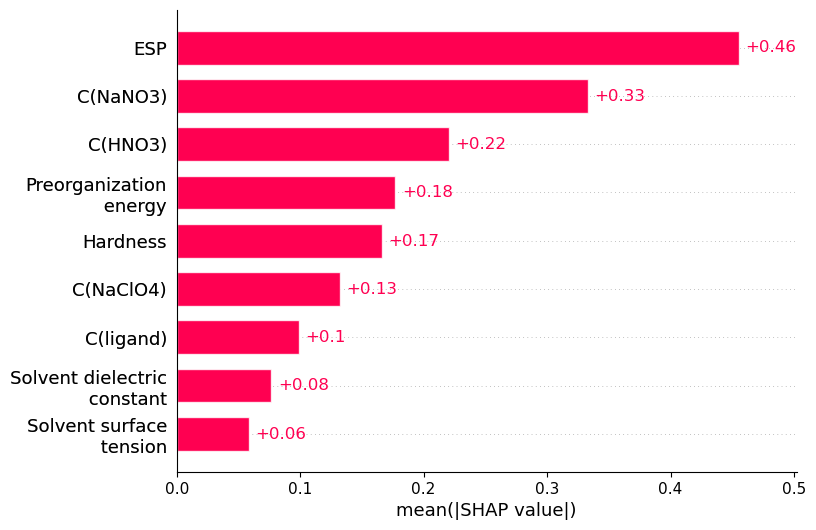

In [72]:
import shap
import matplotlib.pyplot as plt

shap.plots.initjs()

explainer = shap.Explainer(model, X_df)
shap_values = explainer(X_df)
clustering = shap.utils.hclust(X, target)
shap.plots.bar(shap_values)
# shap.plots.force(explainer.expected_value, shap_values)#, max_display=12, order=shap.Explanation.abs.mean(0))

In [73]:
["ESP", "Preorganization\n energy", "Hardness", "Solvent dielectric\n constant", "Solvent surface\n tension"]

['ESP',
 'Preorganization\n energy',
 'Hardness',
 'Solvent dielectric\n constant',
 'Solvent surface\n tension']

In [74]:
shap_values[0]

.values =
array([ 0.69290193,  0.32446143,  0.13485366,  0.07899537,  0.11337147,
        0.07411758,  0.36120402,  0.66717792, -0.09374328])

.base_values =
0.01028330753817723

.data =
array([ 1.00000000e+00,  1.00000000e-04,  0.00000000e+00,  1.00000000e-01,
        2.50000000e+01,  3.06000000e+01,  2.26335000e+00, -9.98044600e-01,
        3.71246193e+00])

In [75]:
from plotly import graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Control',
    x=order, y=[np.mean(np.abs(shap_values.values[:, i])) for i, name in enumerate(order)],
    error_y=dict(type='data', array=[np.std(np.abs(shap_values.values[:, i])) for i, name in enumerate(order)])
))

fig.update_layout(barmode='group')
fig.show()

In [76]:
from plotly.subplots import make_subplots
import plotly.express as px
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
colors = px.colors.qualitative.Plotly

fig.add_trace(go.Bar(x=["ESP", "Preorganization\n energy", "Hardness", "Solvent dielectric\n constant", "Solvent surface\n tension"],
                y=[np.mean(np.abs(shap_values.values[:, i])) for i, name in enumerate(order[4:])],
                error_y=dict(type='data', array=[np.std(np.abs(shap_values.values[:, i])) for i, name in enumerate(order[4:])]),
                marker_color=colors[0],
                ), row=1, col=1)
fig.add_trace(go.Bar(x=["C(NaNO3)", "C(HNO3)", "C(NaClO4)", "C(ligand)"],
                y=[np.mean(np.abs(shap_values.values[:, i])) for i, name in enumerate(order[:4])],
                error_y=dict(type='data', array=[np.std(np.abs(shap_values.values[:, i])) for i, name in enumerate(order[:4])]),
                marker_color=colors[0],
                ), row=1, col=2)
fig.update_layout(width=800,
                  height=800,
                  showlegend=False
                 )

fig.update_xaxes(mirror=True, ticks='outside', showline=True)
fig.update_yaxes(mirror=True, ticks='outside', showline=True)
fig.update_layout(
    template="plotly_white",
    yaxis_title="mean(|Shapley|)",
    # xaxis_title=x_title,
    font=dict(
        size=20,
    )
)

fig.update_xaxes(showline=True, linewidth=0.5, linecolor='black', gridwidth=0.1, gridcolor='gray', zeroline=True,
                    zerolinewidth=0.1, zerolinecolor='black')

fig.update_yaxes(showline=True, linewidth=0.5, linecolor='black', gridwidth=0.1, gridcolor='gray', zeroline=True,
                    zerolinewidth=0.1, zerolinecolor='black')
fig.show()

In [31]:
from rdkit.Chem import Draw
from rdkit import Chem
import PIL
from matplotlib.pyplot import imshow
from os import path
root_dir = "indiv_mols_waterfalls"

print(len(sf_df["smiles"]))
for i in range(len(sf_df["smiles"])):
    try:
        smiles = sf_df["smiles"][i]
        img = Draw.MolToImage(Chem.MolFromSmiles(sf_df["smiles"][i]))
        img.save(path.join(root_dir, f"{smiles}_{i}.png"))
        shap.plots.waterfall(shap_values[i], show=False)
        plt.savefig(path.join(root_dir, f"{smiles}_{i}_wf.png"))
        plt.clf()
        shap.plots.force(shap_values[i], show=False, matplotlib=True)
        plt.savefig(path.join(root_dir, f"{smiles}_{i}_f.png"))
        plt.clf()
    except:
        print(i)

74


/home/cairne/Apps/micromamba/envs/actstabml/lib/python3.10/site-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



49
50
63


In [77]:
for i, name in enumerate(order):
    # print(shap_values[:, i].values)
    # shap.plots.scatter(shap_values[:, i], show=False, alpha=0.6)
    # plt.show()
    print(name)


C(NaNO3)
C(HNO3)
C(NaClO4)
C(ligand)
Solvent dielectric
 constant
Solvent surface
 tension
Hardness
ESP
Preorganization
 energy


In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

# Add traces to each subplot
fig.add_trace(go.Scatter(x=shap_values[:, -3].data, y=shap_values[:, -3].values, name='Hardness', mode='markers'), row=1, col=1)
fig.add_trace(go.Scatter(x=shap_values[:, -2].data, y=shap_values[:, -2].values, name='ESP', mode='markers'), row=1, col=2)
fig.add_trace(go.Scatter(x=shap_values[:, -1].data, y=shap_values[:, -1].values, name='Preorganization\n energy', mode='markers'), row=1, col=3)

# Update layout for better visibility
fig.update_xaxes(mirror=True, ticks='outside', showline=True)
fig.update_yaxes(mirror=True, ticks='outside', showline=True)
fig.update_xaxes(showline=True, linewidth=0.5, linecolor='black', gridwidth=0.1, gridcolor='gray', zeroline=False,
                    zerolinewidth=0.1,)

fig.update_yaxes(showline=True, linewidth=0.5, linecolor='black', gridwidth=0.1, gridcolor='gray', zeroline=False,
                    zerolinewidth=0.1,)

fig.update_layout(showlegend=False)
fig.update_layout({  
    "plot_bgcolor": "rgba(0, 0, 0, 0)",  
    "paper_bgcolor": "rgba(0, 0, 0, 0)",  
})

fig.update_layout(  
    font=dict(  
        size=16,  
    )  
)
fig.update_xaxes(title_text='Hardness, eV', row=1, col=1)
fig.update_xaxes(title_text='ESP, V', row=1, col=2)
fig.update_xaxes(title_text='Preorganization\n energy, eV', row=1, col=3)
fig.update_yaxes(title_text='SHAP value', row=1, col=1)
# Show the figure
fig.write_image(f"SHAP_correlations.png", width=1000)


In [79]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 3))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
fig.savefig("plots/scatter_top5.png")


NameError: name 'masv' is not defined

In [ ]:
# col2num = {col: i for i, col in enumerate(X_df.columns)}

# order = list(map(col2num.get, order))

shap.plots.beeswarm(shap_values, max_display=12, show=False, color_bar=False, order=order)
plt.colorbar()
plt.show()